#Chapter 2 - Stepping up with SciPy

Numpy is a powerful, yet very basic library, which can be a little abstract to introduce -- and a little tedious to practice. To perform more interesting things to Numpy matrices, we now turn to a number of interesting libraries, which have been built around numpy, or which were designed to interact closely with it.

# Clustering with Scipy

SciPy stands for 'Scientific Python': as its name suggests, this library extends Numpy's raw number crunching capabilities, with interesting scientific functionality, including the calculation of distances between vectors, or common statistical tests. Scipy is commonly imported under the name `sp`:

In [16]:
import scipy as sp

###Loading the data
It is time to get practical! In the `data` directory in the repository for this course, I have included a corpus representing novels by three famous British authors from the Victorian era: Jane Austen, Charles Dickens, and William Thackeray. In the next code block, I load these texts and turn them into a vectorized matrix. You can simple execute the code block and ignore it for the time being. In the next chapter, we will deep deeper into the topic of vectorization.

In [17]:
import pickle
titles, authors, words, X = pickle.load(open("dummy.p", "rb")) # dummy contained the data ;)

As you can see we loaded a list of titles, authors, words and a frequency table - which is named capital X. These lists are perfectly matched: the authors and titles can for instance be easily zipped together:

In [18]:
print('This dummy corpus holds:')
for title, author in zip(titles, authors):
    print('\t-', title, 'by', author)

This dummy corpus holds:
	- Emma by Austen
	- Pride by Austen
	- Sense by Austen
	- Bleak by Dickens
	- David by Dickens
	- Hard by Dickens
	- Barry by Thackeray
	- Pendennis by Thackeray
	- Vanity by Thackeray


The `X` matrix which we loaded has frequency information for these texts, concerning the 100 most frequenct words in the texts. Each column in `X` corresponds to the relative frequencies for a particular word: 

In [19]:
print(X.shape) # X is a numpy.ndarray

(9, 100)


The lists of words matches the names of the columns in our frequency table. To select the frequencies for the pronoun 'my' in each text, we could therefore do:

In [20]:
idx_my = words.index('my') # index of 'my' in the word list
freqs_my = X[:, idx_my]
print(type(freqs_my))

<class 'numpy.ndarray'>


If you are interested in getting a version of this matrix which is easier to deal with, `pandas` is an interesting library. Basically, it wraps a lot of functionality around numpy matrixes, and makes it easier to access, for instance, columns using actual names, instead of less intuitive indices. Thus, it brings a lot of functionality to Python which you might know from e.g. R. Pandas is imported as `pd` conventionally: 

In [21]:
import pandas as pd

To turn `X` into a pandas `DataFrame` (which is the most important object in pandas), we could do this:

In [22]:
df = pd.DataFrame(X, columns=words, index=titles)

This command will construct a nice table out of our data matrix, which can be easily indexed. The example with 'my' above: 

In [23]:
df['my']

Emma         0.050251
Pride        0.069585
Sense        0.049688
Bleak        0.100321
David        0.173879
Hard         0.050252
Barry        0.158682
Pendennis    0.037322
Vanity       0.041704
Name: my, dtype: float64

One very nice property of pandas, it that it can be easily used to move around data in a variety of formats (which is what I mainly use it for). Creating a LaTeX representation of this matrix, for instance, is super-easy:

In [24]:
df.to_latex()[:1000]

'\\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}\n\\toprule\n{} &         a &     about &     after &       all &        am &        an &       and &       any &       are &        as &        at &        be &      been &    before &     being &       but &        by &       can &     could &       did &        do &     every &       for &      from &      good &     great &       had &       has &      have &        he &       her &       him &       his &       how &         i &        if &        in &      into &        is &        it &      know &    little &      made &       man &        me &      miss &      more &        mr &       mrs &      much &      must &        my &     never &        no &       not &       now &        of &       old &        on &       one &      only &        or &       out &       own &      said &       say &       she &    should &       sir &        so &      some &      such 

Saving and writing data is also possible for a whole bunch of other formats, including Excel, csv, etc.

###Clustering

One common methodology in stylometry is clustering: by drawing a tree diagram or 'dendrogram', representing the relationships between the texts in a corpus, we attempt to visualize the main stylistic structure in our data. Texts that cluster together under a similar branch in the resulting diagram, can be argued to be stylistically closer to each other, than texts which occupy completely different places in the tree. Texts by the same authors, for instance, will often form thight clades in the tree, because they are written in a similar style.

Clustering algorithms are based on the distances between texts: clustering algorithms typically start by calculating the distance between each pair of texts in a corpus, so that know for each text how (dis)similar it is from any other text. Only after these distances have been fully calculated, we have the clustering algorithm start building a tree representation, in which the similar texts are joined together and merged into new nodes. To create a distance matrix, scipy offers the convenient functions `pdist` and `squareform`, which can be used to calculate the pairwise distances between all the rows in a matrix (i.e. all the texts in a corpus, in our case):

In [25]:
from scipy.spatial.distance import pdist, squareform # necessary for clustering

We can now run this function on our corpus. To obtain a nice and clean matrix, we apply `squareform()` to `pdist`()'s: result: like that, we obtain a matrix which has a row as well as a column for each of our original texts. This representation is a bit superfluous, because `matrix[i][j]` will be identical to `matrix[j][i]`. This is because most distance metrics in stylometry are symmetric (such as the cityblock or Manhattan distance used below): the distance of document B to document A is equal to the distance from document A to document B. 

In [26]:
dm = squareform(pdist(X, 'cityblock'))
print(dm.shape)

(9, 9)


As is clear from the shape info, we have obtained a 9 by 9 matrix, which holds the distance between each pair of texts. Note that the distance from a text to itself is of course zero:

In [27]:
print(dm[3][3]) # diagonals
print(dm[8][8])

0.0
0.0


Additionally, the distance from text A to text B, is equal to the distance from B to A:

In [28]:
print(dm[2][3] == dm[3][2])# check if both halves are the same


True


To be able to visualize a dendrogram, we must first take care of the linkages in the tree: this procedure will start by merging ('linking') the most similar texts in the corpus into a new mode; only at a later stage in the tree, these nodes of very similar texts will be joined together with nodes representing other texts. We perform this - fairly abstract - step on our distance matrix as follows:

In [29]:
from scipy.cluster.hierarchy import linkage
linkage_object = linkage(dm, method='ward')

Here, we specify that we wish to use Ward's linkage method, which is one of the most common linkage functions in stylometry. We are now ready to draw the actual dendrogram. To make sure that our plots are properly displayed in the notebook, we must first execute this line:

In [30]:
%matplotlib inline

We can now draw our dendrogram. Note that we annotate the outer leaf nodes in our tree (i.e. the texts) using the `labels` argument. With the `orientation` argument, we make sure that our dendrogram can be easily read:  

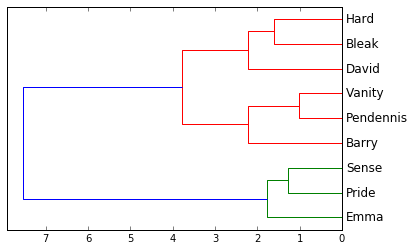

In [31]:
from scipy.cluster.hierarchy import dendrogram
linkage_object = linkage(dm, method='ward')
d = dendrogram(Z=linkage_object, labels=titles, orientation='right')

7 = large, 0 = small distance.
The dendrogram shows the reduction of variance when a node is joined. Better not use this on large data sets ;)

Using the authors as labels is of course also a good idea:

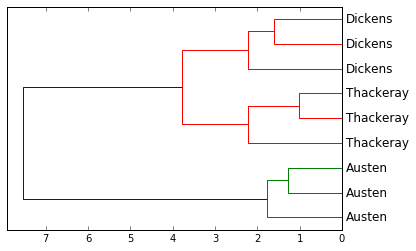

In [32]:
from scipy.cluster.hierarchy import dendrogram
linkage_object = linkage(dm, method='ward')
d = dendrogram(Z=linkage_object, labels=authors, orientation='right')

As we can see, Jane Austen's novels form a tight and distinctive cloud; apparantly Dickens and Thackeray are more difficult to tell apart. The actual distance between nodes is hinted at on the horizontal length of the branches (i.e. the values on the x-axis in this plot). The previous code blocks used the Manhattan city block distance, a very simple distance metric which is also used in the calculation of Burrows's Delta. Note that we can easily switch to, for instance, the Euclidean distance:

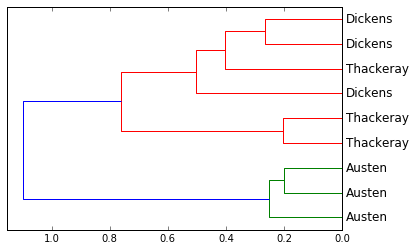

In [33]:
dm = squareform(pdist(X, 'euclidean'))
linkage_object = linkage(dm, method='ward')
d = dendrogram(Z=linkage_object, labels=authors, orientation='right')

this last plot is worse from the view of authorship attribution: there's a thackeray between the dickenses

In [ ]:
???

Matplotlib is still the standard plotting library for Python -- and it is in fact the one which is used to produce the dendrograms above. Nevertheless, it is not particularly aesthetically pleasing. One interesting alternative which has recently surfaced is [seaborn](http://stanford.edu/~mwaskom/software/seaborn/index.html): it is in fact not a replacement for matplotlib but rather a better styled version of Matplotlib. It is imported as `sns` by convention (make sure that you install it first):  

In [34]:
import seaborn as sns

/usr/lib64/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Interestingly, seaborn comes with a series of interesting visualization options. One option which I have used in the recent past, is its clustermap(). When passing it a data set (such as our distance matrix `dm` above), it will draw a heatmap, and then annotate the axis with cluster tree. In the following code block, we show how we can use seaborn to create such a clustermap. Note that we first convert the distance matrix into a pandas DataFrame. 

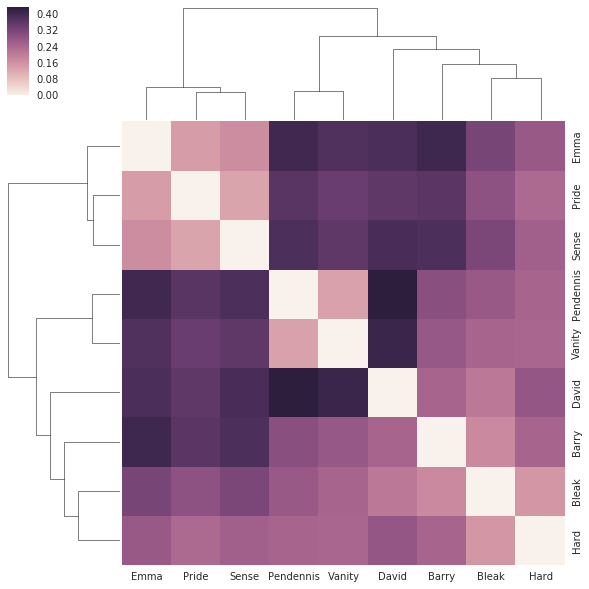

In [36]:
import pandas as pd
df = pd.DataFrame(dm, columns=titles, index=titles)
cm = sns.clustermap(df)

This clustermap offers an excellent visualization of the stylistic structure in our data. Apart from the cluster trees which we already obtained, the lighter areas in the heatmap intuitively point to specific text combinations that display a lot of stylistic affinity. 

##A simple Burrows's Delta in SciPy

SciPy is flexible enough to be useful for a variety of analyses. One interesting application which is easy to implement with SciPy is Burrows's Delta, a well-known attribution method in stylometry. We select a single text as an 'unknown' test text (`test_vector`), which we will try to attribute to one of the authors in our corpus. We therefore split our data:

In [ ]:
test_vector = X[0]
X_train = X[1:]
print(test_vector.shape)
print(X_train.shape)

Thus, we obtain a single test vector, consisting of 30 features, and a 8 by 30 matrix of training texts: i.e. the texts of our 'known' authors. We can now calculate to which training text our unknown test text is closest, using the Manhattan distance implemented in scipy:

In [ ]:
from scipy.spatial.distance import cityblock as manhattan

This metric can be used to calculate the cityblock distance between any two vectors, as follows:

In [ ]:
print(manhattan(test_vector, X_train[3]))

We could have easily coded this ourselves:

In [ ]:
d = 0.0
for a, b in zip(test_vector, X_train[3]):
    d += abs(a-b)
print('Distance: ', d)

We now proceed to calculate the distance between our anonymous text and all texts in our training set:

In [ ]:
dists = []
for v in X_train:
    dists.append(manhattan(test_vector, v))
print(dists)

Or with a list comprehension:

In [ ]:
dists = [manhattan(test_vector, v) for v in X_train]
print(dists)

As you can see, this yields a list of 8 values: the respective distances between our test_vector and all training items. Now, we can use some convenient numpy functions, to find out which training texts shows the minimal distance to our anonymous text:

In [ ]:
import numpy as np
nearest_dist = np.min(dists)
print('Smallest distance: ', nearest_dist)

Apparently, the smallest distance we obtain is close to 1.04. (Note how numpy automatically casts our list of distances to an array.) As to the largest distance:

In [ ]:
largest_dist = np.max(dists)
print('Largest distance: ', largest_dist)

At this point, however, we still don't know to _which exact_ training item our test item is closest. For this purpose, we can the use the `argmin()` function. This will not return the actual minimal distance, but rather the _index_ at which the smallest value can be found:

In [ ]:
nn_idx = np.argmin(dists) # index of the nearest neighbour
print('Index of nearest neighbour: ', nn_idx)

Apparently, the test vector's nearest neighbour can be found in first position; this is in fact a text by the author we where looking for:

In [ ]:
print('Closest text:', titles[nn_idx])
print('Closest author:', authors[nn_idx])

With `pdist('cityblock')`, we can calculate the pairwise distances between all rows in a single matrix; using `sp.spatial.distance.cityblock()`, we can calculate the same Manhattan distance between two vectors. What can we do when we would like to calculate the distances between all the rows in one matrix, to all the rows in another matrix? This is a valid question, since often we would like to attribute more than one anonymous text to a series of candidate authors. This is where scipy's `cdist()` function comes in handy: 

In [ ]:
from scipy.spatial.distance import cdist

Let us mimick that our test_vector is in fact a list of anonymous texts:  

In [ ]:
X_test = [test_vector, test_vector]

Using `cdist()` we can now calculate the distance between all our test items and all our train items:

In [ ]:
dists = cdist(X_test, X_train, metric='cityblock')
print(dists)
print(dists.shape)

As you can see, we now obtain a 2 x 8 matrix, which holds for every test texts (first dimension), the distance to all training items (second dimension). To find the training indices which minize the distance for each test item we can again use `argmin()`. Note that here we have to specify `axis=1`, because we are interested in the minima in the second dimension:  

In [ ]:
np.argmin(dists, axis=1)

While implementing this simple version of Burrows's Delta in Scipy is child's play, we will show in the next chapter that packages such as `scikit-learn` make this even simpler.

-----------------------------